# Лабораторная работа №2
### Прогнозирование временных рядов с помощью аппарата ИНС
Подготовили: Поминова Алена, Жарковский Никита, Цыганкова Елизавета 


In [1]:
from google.colab import files 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, SimpleRNN
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.layers.convolutional import Conv1D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv1D, Dense, MaxPool1D, Flatten, Input


# Подготовка данных

In [2]:
#Загружаем выборку и делаем предобработку, убрав 3 первые колонки
def getData(df):
  data = df
  return data.drop(columns=['ti', '10*sin(ti)', 'empty'], axis=1).astype(float)
#Получаем данные из файла
def getDataFromFile(fileName):
  df = pd.read_csv(fileName, sep=',') #Считываем файл с помощью pandas
  return getData(df)                  #Возвращаем считанные данные из файла

In [3]:
#Считываем данные из файла
data_m3 = getDataFromFile('m3.csv')
print(data_m3.head(5))
print(data_m3.shape)

data_m4 = getDataFromFile('m4.csv')
print(data_m4.head(5))
print(data_m4.shape)

data_m5 = getDataFromFile('m5.csv')
print(data_m5.head(5))
print(data_m5.shape)

         x1        x2        x3         y
0  0.000000  0.998334  1.986693  6.442177
1  0.998334  1.986693  2.955202  7.173561
2  1.986693  2.955202  3.894183  7.833269
3  2.955202  3.894183  4.794255  8.414710
4  3.894183  4.794255  5.646425  8.912074
(200, 4)
         x1        x2        x3        x4         y
0  0.000000  0.998334  1.986693  2.955202  7.173561
1  0.998334  1.986693  2.955202  3.894183  7.833269
2  1.986693  2.955202  3.894183  4.794255  8.414710
3  2.955202  3.894183  4.794255  5.646425  8.912074
4  3.894183  4.794255  5.646425  6.442177  9.320391
(200, 5)
         x1        x2        x3        x4        x5         y
0  0.000000  0.998334  1.986693  2.955202  3.894183  7.833269
1  0.998334  1.986693  2.955202  3.894183  4.794255  8.414710
2  1.986693  2.955202  3.894183  4.794255  5.646425  8.912074
3  2.955202  3.894183  4.794255  5.646425  6.442177  9.320391
4  3.894183  4.794255  5.646425  6.442177  7.173561  9.635582
(200, 6)


In [4]:
data_m3 = data_m3[0:193]
print(data_m3.tail(5))

data_m4 = data_m4[0:192]
print(data_m4.tail(5))

data_m5 = data_m5[0:191]
print(data_m5.tail(5))

           x1        x2        x3         y
188 -0.495356  0.504227  1.498772  6.055399
189  0.504227  1.498772  2.478342  6.819636
190  1.498772  2.478342  3.433149  7.515734
191  2.478342  3.433149  4.353654  8.136737
192  3.433149  4.353654  5.230658  8.676441
           x1        x2        x3        x4         y
187 -1.489990 -0.495356  0.504227  1.498772  6.055399
188 -0.495356  0.504227  1.498772  2.478342  6.819636
189  0.504227  1.498772  2.478342  3.433149  7.515734
190  1.498772  2.478342  3.433149  4.353654  8.136737
191  2.478342  3.433149  4.353654  5.230658  8.676441
           x1        x2        x3        x4        x5         y
186 -2.469737 -1.489990 -0.495356  0.504227  1.498772  6.055399
187 -1.489990 -0.495356  0.504227  1.498772  2.478342  6.819636
188 -0.495356  0.504227  1.498772  2.478342  3.433149  7.515734
189  0.504227  1.498772  2.478342  3.433149  4.353654  8.136737
190  1.498772  2.478342  3.433149  4.353654  5.230658  8.676441


In [5]:
#Функция зашумления y
def create_noise_data(idata):
    newDataFrame = idata.copy()

    noise = np.random.uniform(low=0, high=9, size=newDataFrame.shape[0])
    
    for i in range(0, newDataFrame.shape[0]):
        if noise[i] <= 2:
            noise_pr = np.random.uniform(low=1e-10, high=9)
            newDataFrame['y'][i] = newDataFrame['y'][i]*(1+noise_pr/100)
        if noise[i] >= 7:
            noise_pr = np.random.uniform(low=1e-10, high=9)
            newDataFrame['y'][i] = newDataFrame['y'][i]*(1-noise_pr/100)    

    return newDataFrame

In [6]:
data_m3_noise = create_noise_data(data_m3)
print(data_m3_noise.head(5))
print(data_m3_noise.shape)

data_m4_noise = create_noise_data(data_m4)
print(data_m4_noise.head(5))
print(data_m4_noise.shape)

data_m5_noise = create_noise_data(data_m5)
print(data_m5_noise.head(5))
print(data_m5_noise.shape)

         x1        x2        x3         y
0  0.000000  0.998334  1.986693  6.442177
1  0.998334  1.986693  2.955202  6.764226
2  1.986693  2.955202  3.894183  7.833269
3  2.955202  3.894183  4.794255  8.414710
4  3.894183  4.794255  5.646425  8.912074
(193, 4)
         x1        x2        x3        x4         y
0  0.000000  0.998334  1.986693  2.955202  6.730394
1  0.998334  1.986693  2.955202  3.894183  7.833269
2  1.986693  2.955202  3.894183  4.794255  8.414710
3  2.955202  3.894183  4.794255  5.646425  8.912074
4  3.894183  4.794255  5.646425  6.442177  9.824368
(192, 5)
         x1        x2        x3        x4        x5         y
0  0.000000  0.998334  1.986693  2.955202  3.894183  7.833269
1  0.998334  1.986693  2.955202  3.894183  4.794255  8.121417
2  1.986693  2.955202  3.894183  4.794255  5.646425  9.102239
3  2.955202  3.894183  4.794255  5.646425  6.442177  9.320391
4  3.894183  4.794255  5.646425  6.442177  7.173561  8.897800
(191, 6)


In [7]:
#Функция для отрисовки исходных данных
def print_data(data, m):
  #Отображаем исходные данные от точки start и длиной step
  start = 0 #С какой точки начинаем
  step = data.shape[0] #Сколько точек отрисуем
  #Заполняем текстовые названия каналов данных
  chanelNames = list(data.columns) # ['x1', 'x2', 'x3', ...]
  #Рисуем все графики данных
  plt.figure(figsize=(10,5))
  for i in range(m):
    #Отрисовываем часть данных
    #От начальной точки, до начальной точки + размер шага отрисовки
    plt.plot(data.iloc[start:start+step, i], label=chanelNames[i])
  plt.legend()
  plt.show()

#Функция для отрисовки исходных данных y
def print_data_y(data, m):
  plt.figure(figsize=(10,5))
  start = 0
  step = data.shape[0]
  plt.plot(data.iloc[start:start+step, m], label="y")
  plt.legend()
  plt.show()

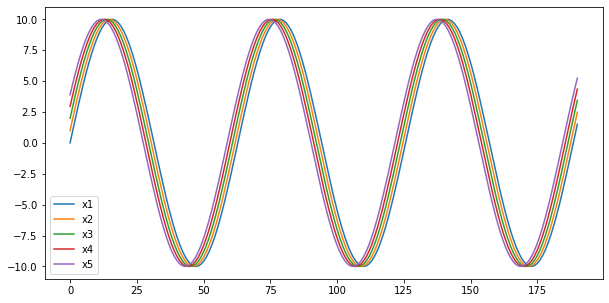

In [8]:
print_data(data_m5, 5)

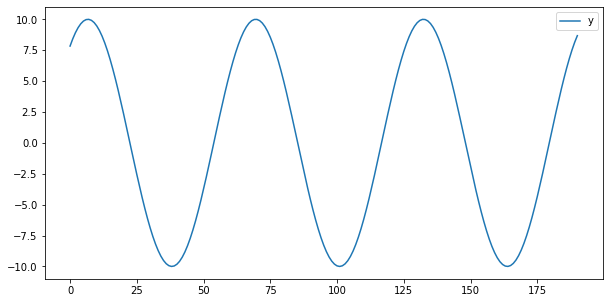

In [9]:
print_data_y(data_m5, 5)

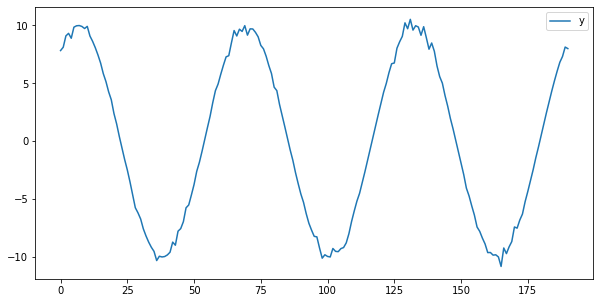

In [10]:
print_data_y(data_m5_noise, 5)

# Код подготовки данных для временного ряда

In [11]:
#data - Numpy array
def DataNormalization(data, Channels):
  #Тип нормализации - нормальное распределение
  scaler = StandardScaler()
  #Берём только те каналы, которые указаны в аргументе функции
  resData = data.iloc[:,Channels]
  if (len(resData.shape) == 1): #Если размерность входного массива - одномерный вектор, 
    print("Add one dimension")
    resData = np.expand_dims(resData, axis=1) #то добавляем размерность
  #Обучаем нормировщик
  scaler.fit(resData)
  #Нормируем данные
  resData = scaler.transform(resData)
  return (resData, scaler)

In [12]:
#data - данные
#xLen - размер фрема, по которому предсказываем
#xChannels - лист, номера каналов, по которым делаем анализ
#yChannels - лист, номера каналов, которые предсказываем
#stepsForward - на сколько шагов предсказываем в будущее
#если 1 - то на 1 шаг, можно использовать только при одном канале, указанном в yChannels
#valLen - сколько примеров брать для проверочной выборки (количество для обучающей посчитается автоматиески)
def getXTrainFromTimeSeries(data, xLen , xChannels, yChannels, stepsForward, valLen):
  
  #Нормализуем x
  (xData, xScaler) = DataNormalization(data, xChannels)
  # без нормализациии совсем плохо получается
  #xData = np.array(data.iloc[:,xChannels]) 
  
  #Нормализуем y
  (yData, yScaler) = DataNormalization(data, yChannels)
  #yData = np.array(data.iloc[:,yChannels])

  #Формируем xTrain
  
  #Разбиваем исходный ряд на куски xLen с шагом 1
  xTrain = np.array([xData[i:i + xLen, xChannels] for i in range(xData.shape[0] - xLen + 1 - stepsForward)])  
  
  #Разбиваем исходный ряд на куски xLen с шагом xLen (без 'раскусывания', результат хуже)
  #xTrain = np.array([xData[i:i + xLen, xChannels] for i in range(0, xData.shape[0] - xLen + 1, xLen)]) 
  
  #Формируем yTrain
  #Берём stepsForward шагов после завершения текущего x
  if (stepsForward > 1):
    #yTrain = np.array([yData[i:i + xLen, [0]] for i in range(0, yData.shape[0] - xLen + 1, xLen)]) #с шагом xLen (без 'раскусывания', результат хуже)
    yTrain = np.array([yData[i:i + stepsForward, [0]] for i in range(xLen, yData.shape[0] + 1 - stepsForward)]) #с шагом 1
  else:
    yTrain = np.array([yData[i, [0]] for i in range(xLen, yData.shape[0] + 1 - stepsForward)]) #с шагом 1

  #Расчитываем отступ между обучающими о проверочными данными
  #Чтобы они не смешивались
  xTrainLen = xTrain.shape[0]
  bias = 1

  #Берём из конечной части xTrain проверочную выборку
  xVal = xTrain[xTrainLen-valLen:]
  yVal = yTrain[xTrainLen-valLen:]
  
  #Оставшуюся часть используем под обучающую выборку
  xTrain = xTrain[:xTrainLen-valLen-bias]
  yTrain = yTrain[:xTrainLen-valLen-bias]

  return (xTrain, yTrain), (xVal, yVal), (xScaler, yScaler)

In [13]:
#Формируем параметры загрузки данных
xLen = 10
stepsForward = 1 
valLen = 50 #round(data.shape[0]/xLen*0.2)

xChannels_m3 = range(data_m3.drop(['y'], axis=1, inplace=False).shape[1])
yChannels_m3 = [3]

xChannels_m4 = range(data_m4.drop(['y'], axis=1, inplace=False).shape[1])
yChannels_m4 = [4] 

xChannels_m5 = range(data_m5.drop(['y'], axis=1, inplace=False).shape[1])
yChannels_m5 = [5]

xChannels_m3_noise = range(data_m3_noise.drop(['y'], axis=1, inplace=False).shape[1])
yChannels_m3_noise = [3]

xChannels_m4_noise = range(data_m4_noise.drop(['y'], axis=1, inplace=False).shape[1])
yChannels_m4_noise = [4] 

xChannels_m5_noise = range(data_m5_noise.drop(['y'], axis=1, inplace=False).shape[1])
yChannels_m5_noise = [5]

#Загружаем данные
(xTrain_m3, yTrain_m3), (xVal_m3, yVal_m3), (xScaler_m3, yScaler_m3) = getXTrainFromTimeSeries(data_m3, xLen, xChannels_m3, yChannels_m3, stepsForward, valLen)
(xTrain_m4, yTrain_m4), (xVal_m4, yVal_m4), (xScaler_m4, yScaler_m4) = getXTrainFromTimeSeries(data_m4, xLen, xChannels_m4, yChannels_m4, stepsForward, valLen)
(xTrain_m5, yTrain_m5), (xVal_m5, yVal_m5), (xScaler_m5, yScaler_m5) = getXTrainFromTimeSeries(data_m5, xLen, xChannels_m5, yChannels_m5, stepsForward, valLen)

(xTrain_m3_noise, yTrain_m3_noise), (xVal_m3_noise, yVal_m3_noise), (xScaler_m3_noise, yScaler_m3_noise) = getXTrainFromTimeSeries(data_m3_noise, xLen, xChannels_m3_noise, yChannels_m3_noise, stepsForward, valLen)
(xTrain_m4_noise, yTrain_m4_noise), (xVal_m4_noise, yVal_m4_noise), (xScaler_m4_noise, yScaler_m4_noise) = getXTrainFromTimeSeries(data_m4_noise, xLen, xChannels_m4_noise, yChannels_m4_noise, stepsForward, valLen)
(xTrain_m5_noise, yTrain_m5_noise), (xVal_m5_noise, yVal_m5_noise), (xScaler_m5_noise, yScaler_m5_noise) = getXTrainFromTimeSeries(data_m5_noise, xLen, xChannels_m5_noise, yChannels_m5_noise, stepsForward, valLen)

#Выводим размеры данных для проверки
print(xTrain_m3.shape)
print(yTrain_m3.shape)
print(xVal_m3.shape)
print(yVal_m3.shape)

(132, 10, 3)
(132, 1)
(50, 10, 3)
(50, 1)


In [14]:
def getModel(xTrain, yTrain, xVal, yVal):
  model = Sequential()
  model.add(Conv1D(50, 5, input_shape = (xTrain.shape[1], xTrain.shape[2]), activation="linear"))
  model.add(Flatten())
  model.add(Dense(10, activation="linear"))
  model.add(Dense(yTrain.shape[1], activation="linear"))
  model.compile(loss="mse", optimizer=Adam(lr=1e-4))
  history = model.fit(xTrain, 
                      yTrain, 
                      epochs=20, 
                      batch_size=20, 
                      verbose=1,
                      validation_data=(xVal, yVal))
  
  return (model, history)

In [15]:
def print_loss(history, history_noise):
  plt.figure(figsize=(10,5))

  plt.plot(history.history['loss'],label='Средняя абсолютная ошибка на обучающем наборе')
  plt.plot(history.history['val_loss'],label='Средняя абсолютная ошибка на проверочном наборе')

  plt.plot(history_noise.history['loss'],label='Средняя абсолютная ошибка на обучающем наборе зашумленных данных')
  plt.plot(history_noise.history['val_loss'],label='Средняя абсолютная ошибка на проверочном наборе зашумленных данных')

  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

Epoch 1/20
7/7 [==============================] - 1s 88ms/step - loss: 1.1834 - val_loss: 0.8516
Epoch 2/20
7/7 [==============================] - 0s 11ms/step - loss: 0.9260 - val_loss: 0.8183
Epoch 3/20
7/7 [==============================] - 0s 10ms/step - loss: 0.8581 - val_loss: 0.7710
Epoch 4/20
7/7 [==============================] - 0s 10ms/step - loss: 0.7137 - val_loss: 0.6744
Epoch 5/20
7/7 [==============================] - 0s 10ms/step - loss: 0.6332 - val_loss: 0.5799
Epoch 6/20
7/7 [==============================] - 0s 10ms/step - loss: 0.5383 - val_loss: 0.5040
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.5013 - val_loss: 0.4326
Epoch 8/20
7/7 [==============================] - 0s 12ms/step - loss: 0.4424 - val_loss: 0.3734
Epoch 9/20
7/7 [==============================] - 0s 10ms/step - loss: 0.3775 - val_loss: 0.3214
Epoch 10/20
7/7 [==============================] - 0s 11ms/step - loss: 0.3058 - val_loss: 0.2767
Epoch 11/20
7/7 [============

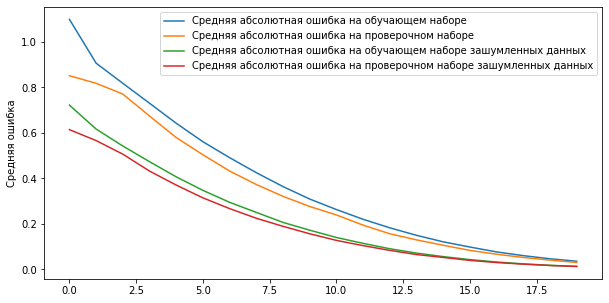

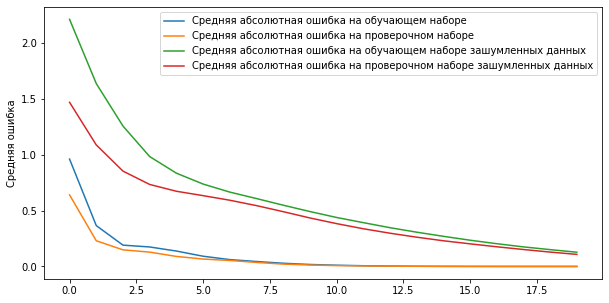

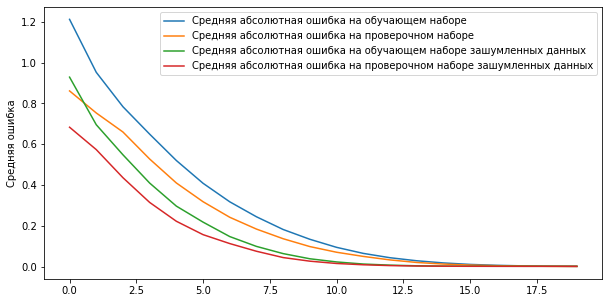

In [16]:
# Обучение
(model_m3, history_m3) = getModel(xTrain_m3, yTrain_m3, xVal_m3, yVal_m3)
(model_m4, history_m4) = getModel(xTrain_m4, yTrain_m4, xVal_m4, yVal_m4)
(model_m5, history_m5) = getModel(xTrain_m5, yTrain_m5, xVal_m5, yVal_m5)

# Обучение с шумом
(model_m3_noise, history_m3_noise) = getModel(xTrain_m3_noise, yTrain_m3_noise, xVal_m3_noise, yVal_m3_noise)
(model_m4_noise, history_m4_noise) = getModel(xTrain_m4_noise, yTrain_m4_noise, xVal_m4_noise, yVal_m4_noise)
(model_m5_noise, history_m5_noise) = getModel(xTrain_m5_noise, yTrain_m5_noise, xVal_m5_noise, yVal_m5_noise)

print_loss(history_m3, history_m3_noise)
print_loss(history_m4, history_m4_noise)
print_loss(history_m5, history_m5_noise)


# Визуализация результатов

In [17]:
#Функция рассчитываем результаты прогнозирования сети
#В аргументы принимает сеть (currModel) и проверочную выборку
#Выдаёт результаты предсказания predVal
#И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  #Предсказываем ответ сети по проверочной выборке
  #И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

In [30]:
#Функция визуализирует графики прогноза сети и правильных ответов
#start - точка с которой начинаем отрисовку графика
#step - длина графика, которую отрисовываем
#channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(10,5))
  plt.plot(predVal[start:start+step, channel], label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], label='Факт')
  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [25]:
#Прогнозируем данные полученными сетями
(predVal_m3, yValUnscaled_m3) = getPred(model_m3, xVal_m3, yVal_m3, yScaler_m3)
(predVal_m4, yValUnscaled_m4) = getPred(model_m4, xVal_m4, yVal_m4, yScaler_m4)
(predVal_m5, yValUnscaled_m5) = getPred(model_m5, xVal_m5, yVal_m5, yScaler_m5)

(predVal_m3_noise, yValUnscaled_m3_noise) = getPred(model_m3_noise, xVal_m3_noise, yVal_m3_noise, yScaler_m3_noise)
(predVal_m4_noise, yValUnscaled_m4_noise) = getPred(model_m4_noise, xVal_m4_noise, yVal_m4_noise, yScaler_m4_noise)
(predVal_m5_noise, yValUnscaled_m5_noise) = getPred(model_m5_noise, xVal_m5_noise, yVal_m5_noise, yScaler_m5_noise)

In [26]:
print(yValUnscaled_m3.reshape(yValUnscaled_m3.shape[0]))
print(yValUnscaled_m4.reshape(yValUnscaled_m4.shape[0]))
print(yValUnscaled_m5.reshape(yValUnscaled_m5.shape[0]))

print(yValUnscaled_m3_noise.reshape(yValUnscaled_m3_noise.shape[0]))
print(yValUnscaled_m4_noise.reshape(yValUnscaled_m4_noise.shape[0]))
print(yValUnscaled_m5_noise.reshape(yValUnscaled_m5_noise.shape[0]))

[ 6.5028784   5.7119687   4.86398689  3.96740573  3.03118357  2.06467482
  1.07753652  0.07963184 -0.9190685  -1.90858581 -2.87903317 -3.82071417
 -4.72421986 -5.58052271 -6.38106682 -7.11785342 -7.78352079 -8.37141778
 -8.87567034 -9.29124013 -9.61397492 -9.84065005 -9.96900066 -9.99774431
 -9.9265938  -9.75626006 -9.48844498 -9.1258245  -8.67202179 -8.13157112
 -7.50987247 -6.81313766 -6.04832822 -5.2230859  -4.34565622 -3.42480619
 -2.46973662 -1.48999026 -0.49535641  0.50422688  1.4987721   2.47834208
  3.43314929  4.3536536   5.23065765  6.0553987   6.8196362   7.51573415
  8.13673737  8.67644101]
[ 6.5028784   5.7119687   4.86398689  3.96740573  3.03118357  2.06467482
  1.07753652  0.07963184 -0.9190685  -1.90858581 -2.87903317 -3.82071417
 -4.72421986 -5.58052271 -6.38106682 -7.11785342 -7.78352079 -8.37141778
 -8.87567034 -9.29124013 -9.61397492 -9.84065005 -9.96900066 -9.99774431
 -9.9265938  -9.75626006 -9.48844498 -9.1258245  -8.67202179 -8.13157112
 -7.50987247 -6.81313766 

In [21]:
import matplotlib
matplotlib.style.use('ggplot')

def print_ggplot(predVal, yValUnscaled):
  plt.figure(figsize=(10,5))
  plt.scatter(predVal, yValUnscaled)
  plt.show()

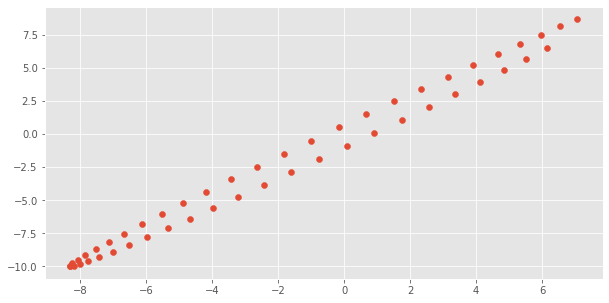

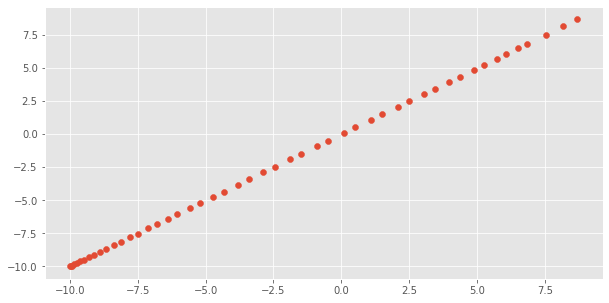

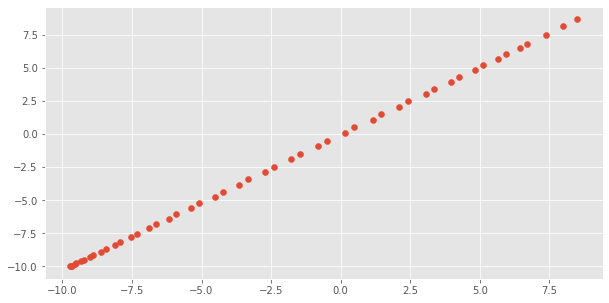

In [27]:
print_ggplot(predVal_m3, yValUnscaled_m3)
print_ggplot(predVal_m4, yValUnscaled_m4)
print_ggplot(predVal_m5, yValUnscaled_m5)

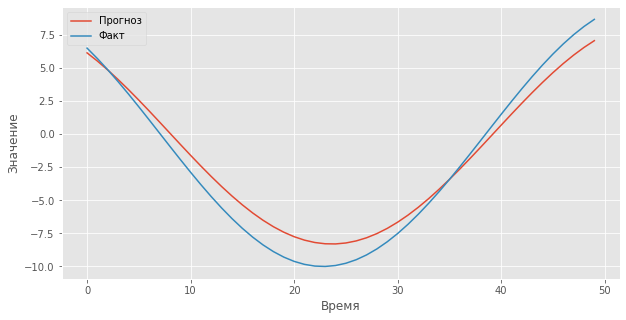

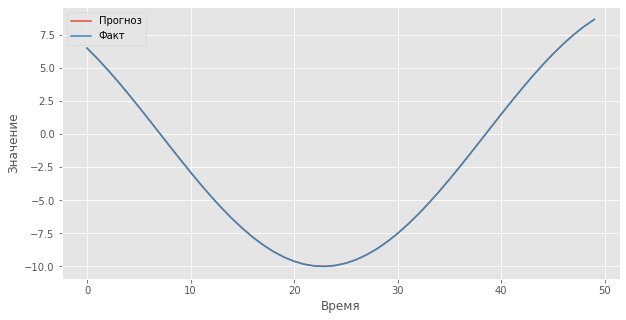

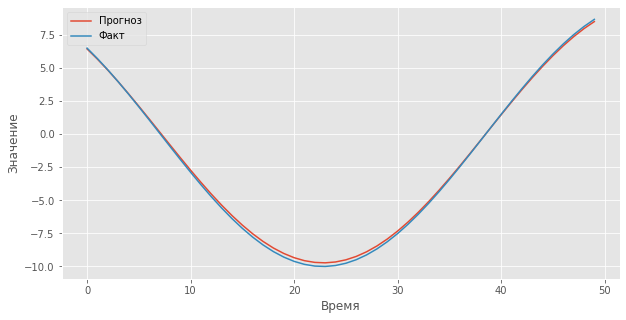

In [31]:
showPredict(0, predVal_m3.shape[0], 0, predVal_m3, yValUnscaled_m3)
showPredict(0, predVal_m4.shape[0], 0, predVal_m4, yValUnscaled_m4)
showPredict(0, predVal_m5.shape[0], 0, predVal_m5, yValUnscaled_m5)

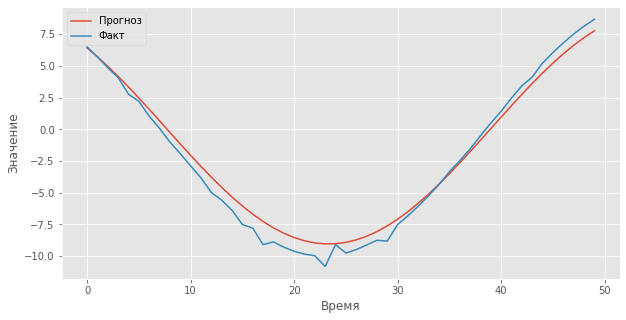

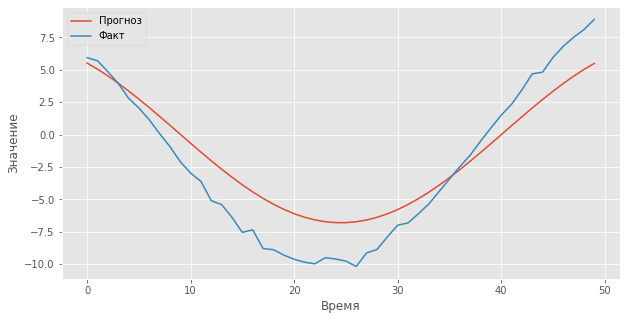

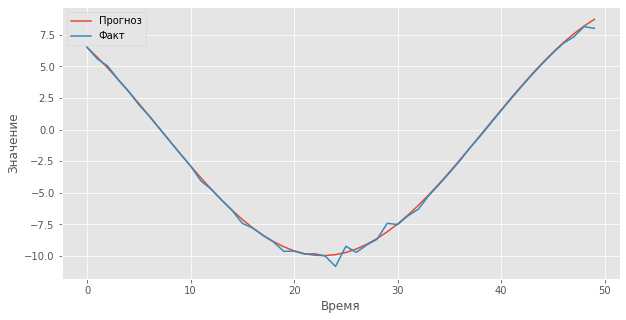

In [24]:
showPredict(0, predVal_m3_noise.shape[0], 0, predVal_m3_noise, yValUnscaled_m3_noise)
showPredict(0, predVal_m4_noise.shape[0], 0, predVal_m4_noise, yValUnscaled_m4_noise)
showPredict(0, predVal_m5_noise.shape[0], 0, predVal_m5_noise, yValUnscaled_m5_noise)